Follows $\texttt{https://github.com/ericmetodiev/OmniFold/blob/master/OmniFold\%20Demo.ipynb}$ but uses pip-installable version of OmniFold

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import copy

import energyflow as ef # for data
import omnifold # for omnifold algorithm

# Local imports for plotting (source: https://github.com/ericmetodiev/OmniFold/blob/master/modplot.py)
import modplot
from hist_utils import obs, calc_obs, hist_style, gen_style, truth_style, omnifold_style, multifold_style, ibu_style

plt.rcParams['figure.figsize'] = (4,6)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

# IBU hyperparameters
N_ITER_IBU = 3

# OmniFold hyperparameters
N_ITER_OF = 5
BATCH_SIZE_OF = 1000
EPOCHS_OF = 2

# Multifold hyperparameters
LAYER_SIZES = [64, 128, 64]
N_ITER_MF = 3
BATCH_SIZE_MF = 500
EPOCHS_MF = 2

# Other globals 
N_DATA = int(1.6e6)
OBS_MULTIFOLD = ['Mass', 'Mult', 'Width', 'Tau21', 'zg', 'SDMass']
N_JOBS = 16

np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)

l10data = int(np.log10(N_DATA))
print(f"N_DATA = {N_DATA/(10**(l10data))}e{int(l10data)}")

2025-03-28 17:59:54.816379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-28 17:59:54.816405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-28 17:59:54.817506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-28 17:59:54.824135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-28 17:59:59.136251: W tensorflow/compiler/tf2

Horovod not found, will continue with single only GPUs.
N_DATA = 1.6e6


In [2]:
print(f'\nTensorflow version = {tf.__version__}\n')
print(f'\n{tf.config.list_physical_devices("GPU")}\n')


Tensorflow version = 2.15.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]



# 1. Load data

We assume, for simplicity:
1. That everything passes the reco and gen cuts
2. That the data is already normalized
3. That the data is uniformly weighted, to begin

We choose Pythia as the Monte Carlo data

In [3]:
data_mc_dict = ef.zjets_delphes.load('Pythia26', num_data=N_DATA, pad=True, source='zenodo', which='all')
obs_mc_gen = {k.replace("gen_", ""): data_mc_dict[k] for k in data_mc_dict.keys() if (('gen_' in k) and ('particle' not in k))}
particle_mc_gen = data_mc_dict['gen_particles']
obs_mc_sim = {k.replace("sim_", ""): data_mc_dict[k] for k in data_mc_dict.keys() if (('sim_' in k) and ('particle' not in k))}
particle_mc_sim = data_mc_dict['sim_particles']

obs_mc_gen['Mass'] = obs_mc_gen['jets'][:,3]
obs_mc_gen.pop('jets')
obs_mc_gen['Mult'] = obs_mc_gen.pop('mults')
obs_mc_gen['Width'] = obs_mc_gen.pop('widths')
obs_mc_gen['Tau21'] = obs_mc_gen.pop('tau2s')
obs_mc_gen['zg'] = obs_mc_gen.pop('zgs')
obs_mc_gen['SDMass'] = obs_mc_gen.pop('sdms')
obs_mc_gen = np.concatenate([obs_mc_gen[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

obs_mc_sim['Mass'] = obs_mc_sim['jets'][:,3]
obs_mc_sim.pop('jets')
obs_mc_sim['Mult'] = obs_mc_sim.pop('mults')
obs_mc_sim['Width'] = obs_mc_sim.pop('widths')
obs_mc_sim['Tau21'] = obs_mc_sim.pop('tau2s')
obs_mc_sim['zg'] = obs_mc_sim.pop('zgs')
obs_mc_sim['SDMass'] = obs_mc_sim.pop('sdms')
obs_mc_sim = np.concatenate([obs_mc_sim[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

And Hedwig as the true/nature data

In [4]:
data_nature_dict = ef.zjets_delphes.load('Herwig', num_data=N_DATA, pad=True, source='zenodo', which='all')
obs_nature_gen = {k.replace("gen_", ""): data_nature_dict[k] for k in data_nature_dict.keys() if (('gen_' in k) and ('particle' not in k))}
particle_nature_gen = data_nature_dict['gen_particles']
obs_nature_sim = {k.replace("sim_", ""): data_nature_dict[k] for k in data_nature_dict.keys() if (('sim_' in k) and ('particle' not in k))}
particle_nature_sim = data_nature_dict['sim_particles']

obs_nature_gen['Mass'] = obs_nature_gen['jets'][:,3]
obs_nature_gen.pop('jets')
obs_nature_gen['Mult'] = obs_nature_gen.pop('mults')
obs_nature_gen['Width'] = obs_nature_gen.pop('widths')
obs_nature_gen['Tau21'] = obs_nature_gen.pop('tau2s')
obs_nature_gen['zg'] = obs_nature_gen.pop('zgs')
obs_nature_gen['SDMass'] = obs_nature_gen.pop('sdms')
obs_nature_gen = np.concatenate([obs_nature_gen[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

obs_nature_sim['Mass'] = obs_nature_sim['jets'][:,3]
obs_nature_sim.pop('jets')
obs_nature_sim['Mult'] = obs_nature_sim.pop('mults')
obs_nature_sim['Width'] = obs_nature_sim.pop('widths')
obs_nature_sim['Tau21'] = obs_nature_sim.pop('tau2s')
obs_nature_sim['zg'] = obs_nature_sim.pop('zgs')
obs_nature_sim['SDMass'] = obs_nature_sim.pop('sdms')
obs_nature_sim = np.concatenate([obs_nature_sim[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

### Construct dataloader objects

In [5]:
# Pad both sets of reco/gen to the same size (number of particles per event)

N_PART_GEN = max(particle_mc_gen.shape[1], particle_nature_gen.shape[1])
N_PART_SIM = max(particle_mc_sim.shape[1], particle_nature_sim.shape[1])
particle_mc_gen = np.concatenate([particle_mc_gen, np.zeros((particle_mc_gen.shape[0], N_PART_GEN-particle_mc_gen.shape[1], 4))], axis=1)
particle_nature_gen = np.concatenate([particle_nature_gen, np.zeros((particle_nature_gen.shape[0], N_PART_GEN-particle_nature_gen.shape[1], 4))], axis=1)
particle_mc_sim = np.concatenate([particle_mc_sim, np.zeros((particle_mc_sim.shape[0], N_PART_SIM-particle_mc_sim.shape[1], 4))], axis=1)
particle_nature_sim = np.concatenate([particle_nature_sim, np.zeros((particle_nature_sim.shape[0], N_PART_SIM-particle_nature_sim.shape[1], 4))], axis=1)

# Construct DataLoaders
obs_mc = omnifold.DataLoader(reco=copy.deepcopy(obs_mc_sim), gen=copy.deepcopy(obs_mc_gen))
particle_mc = omnifold.DataLoader(reco=copy.deepcopy(particle_mc_sim), gen=copy.deepcopy(particle_mc_gen))

# Construct DataLoaders
obs_nature = omnifold.DataLoader(reco=copy.deepcopy(obs_nature_sim), gen=copy.deepcopy(obs_nature_gen))
particle_nature = omnifold.DataLoader(reco=copy.deepcopy(particle_nature_sim), gen=copy.deepcopy(particle_nature_gen))

del obs_mc_sim, obs_mc_gen, particle_mc_sim, particle_mc_gen
del obs_nature_sim, obs_nature_gen, particle_nature_sim, particle_nature_gen 

INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...


## 1.b. Run IBU, construct plotting dictionary

In [6]:
calc_obs(obs_dict=obs, data_synth=data_mc_dict, data_real=data_nature_dict, itnum=N_ITER_IBU)
del data_mc_dict, data_nature_dict

Done with Mass
Done with Mult
Done with Width
Done with Tau21
Done with zg
Done with SDMass


# 2. Load OmniFold

In [10]:
def expit(x):
    return 1. / (1. + np.exp(-x))

In [11]:
N_FEAT_RECO = particle_mc.reco.shape[2]
N_PART_RECO = particle_mc.reco.shape[1]
N_FEAT_GEN = particle_mc.gen.shape[2]
N_PART_GEN = particle_mc.gen.shape[1]
name = "OmniFold"

model_of_reco = omnifold.net.PET(num_feat = N_FEAT_RECO, num_evt = 0, num_part = N_PART_RECO)
model_of_gen = omnifold.net.PET(num_feat = N_FEAT_GEN, num_evt=0, num_part=N_PART_GEN)

model_of = omnifold.MultiFold(
    name=name, 
    model_reco=model_of_reco, 
    model_gen=model_of_gen, 
    data=particle_nature, 
    mc=particle_mc, 
    niter=0,
    batch_size=BATCH_SIZE_OF,
    epochs=EPOCHS_OF,
    size=N_JOBS,
    start=N_ITER_OF,
    n_ensemble=1)

model_of.model1.load_weights('{}/OmniFold_{}_iter{}_step1.weights.h5'.format(model_of.weights_folder,model_of.name,model_of.start-1))
model_of.model2.load_weights('{}/OmniFold_{}_iter{}_step2.weights.h5'.format(model_of.weights_folder,model_of.name,model_of.start-1))
model_of.CompileModels()

model_of.weights_push = np.load(model_of.name 
            + f"_N{N_DATA/(10**(l10data))}e{int(l10data)}" 
            + f"_niter{N_ITER_OF}"
            + f"_bs{BATCH_SIZE_OF}"
            + f"_ep{EPOCHS_OF}"
            + '_weights_push.npy')
model_of.weights_pull = np.load(model_of.name 
            + f"_N{N_DATA/(10**(l10data))}e{int(l10data)}" 
            + f"_niter{N_ITER_OF}"
            + f"_bs{BATCH_SIZE_OF}"
            + f"_ep{EPOCHS_OF}"
            + '_weights_pull.npy')

200 training steps at reco and 200 steps at gen


In [ ]:
model_of_m1_preds = expit(model_of.model1.predict(model_of.data.reco, batch_size=model_of.BATCH_SIZE, verbose=model_of.verbose))
model_of_final_weights = model_of_m1_preds/(1.-model_of_m1_preds)
model_of_final_weights = np.nan_to_num(model_of_final_weights[:,0],posinf=1)

# 3. Load MultiFold

In [2]:
model_mf_reco = omnifold.net.MLP(nvars = len(OBS_MULTIFOLD), layer_sizes=LAYER_SIZES)
model_mf_gen = omnifold.net.MLP(nvars = len(OBS_MULTIFOLD), layer_sizes=LAYER_SIZES)
model_mf = omnifold.MultiFold(
    name="MultiFold", 
    model_reco=model_mf_reco, 
    model_gen=model_mf_gen, 
    data=obs_nature, 
    mc=obs_mc, 
    niter=N_ITER_MF,
    batch_size=BATCH_SIZE_MF,
    epochs=EPOCHS_MF,
    size=N_JOBS)

model_mf.model1.load_weights('{}/OmniFold_{}_iter{}_step1.weights.h5'.format(model_mf.weights_folder,model_mf.name,model_mf.start-1))
model_mf.model2.load_weights('{}/OmniFold_{}_iter{}_step2.weights.h5'.format(model_mf.weights_folder,model_mf.name,model_mf.start-1))
model_mf.CompileModels()

model_mf.weights_push = np.load(model_mf.name 
            + f"_N{N_DATA/(10**(l10data))}e{int(l10data)}" 
            + f"_niter{N_ITER_MF}"
            + f"_bs{BATCH_SIZE_MF}"
            + f"_ep{EPOCHS_MF}"
            + '_weights_push.npy')
model_mf.weights_pull = np.load(model_mf.name 
            + f"_N{N_DATA/(10**(l10data))}e{int(l10data)}" 
            + f"_niter{N_ITER_MF}"
            + f"_bs{BATCH_SIZE_MF}"
            + f"_ep{EPOCHS_MF}"
            + '_weights_pull.npy')

NameError: name 'omnifold' is not defined

In [ ]:
model_mf_m1_preds = expit(model_mf.model1.predict(model_mf.data.reco, batch_size=model_mf.BATCH_SIZE, verbose=model_mf.verbose))
model_mf_final_weights = model_mf_m1_preds/(1.-model_mf_m1_preds)
model_mf_final_weights = np.nan_to_num(model_mf_final_weights[:,0],posinf=1)

# 4. Evaluate with gen and sim

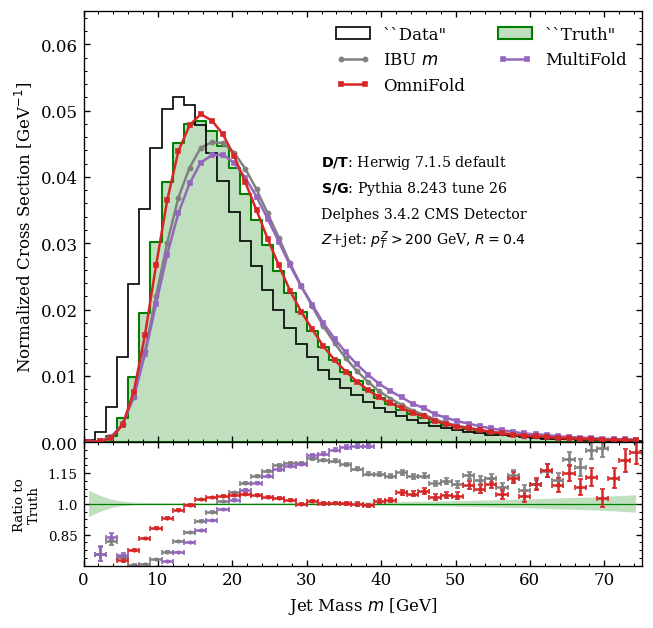

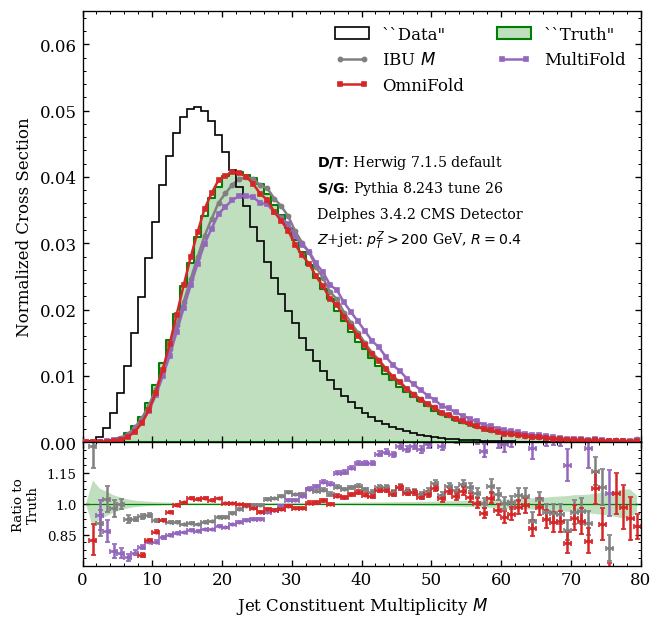

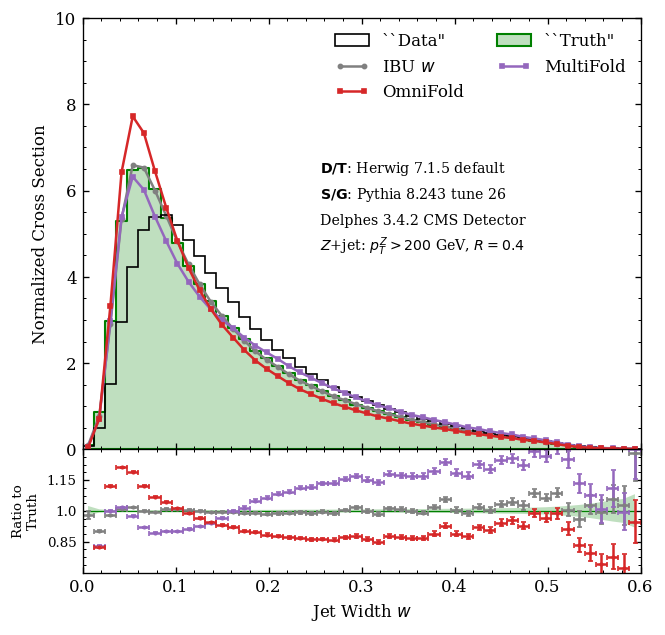

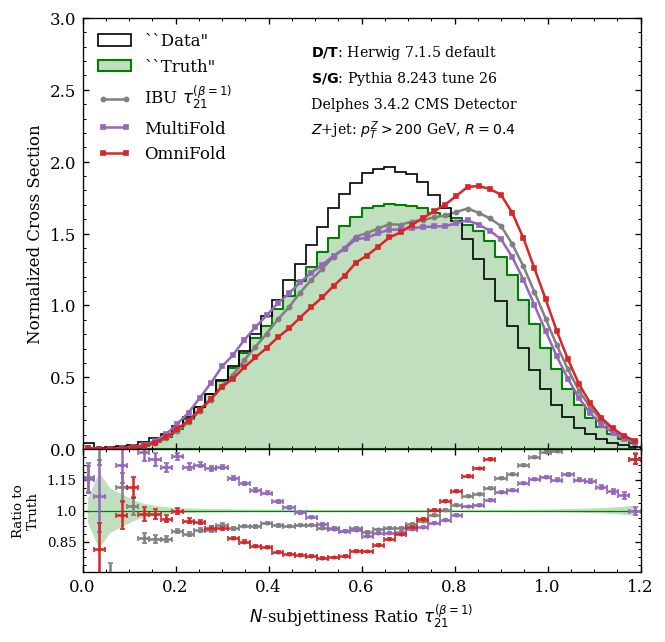

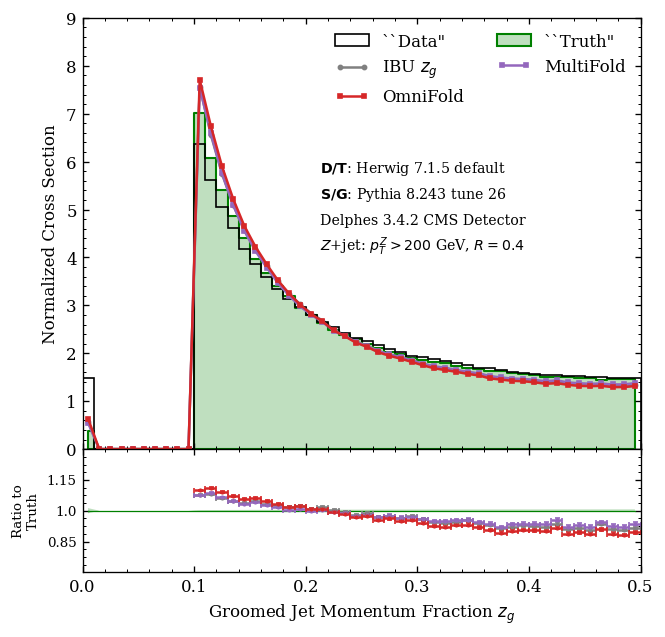

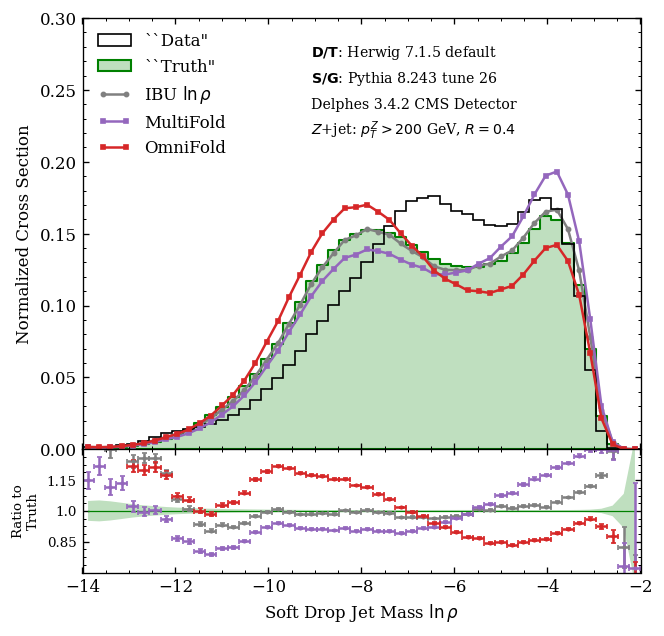

In [19]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob, figsize=(6,6))
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])
        
    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='``Data\"', **hist_style)

    # plot the "truth" histogram of the observable
    ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    # plot the IBU distribution
    ax0.plot(ob['midbins_mc'], ob['ibu_phis'][N_ITER_IBU], **ibu_style, label='IBU ' + ob['symbol'])

    # plot the MultiFold distribution
    mf_histgen, mf_histgen_unc = modplot.calc_hist(ob['genobs'], weights=model_mf.weights_push, 
                                                   bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], mf_histgen, **multifold_style, label='MultiFold')

    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=model_of.weights_push, 
                                                   bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='OmniFold')

    

    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    ibu_ratio = ob['ibu_phis'][N_ITER_IBU]/(ob['truth_hist'] + 10**-50)
    mf_ratio = mf_histgen/(ob['truth_hist'] + 10**-50)
    of_ratio = of_histgen/(ob['truth_hist'] + 10**-50)
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)
    ibu_unc_ratio = ob['ibu_phi_unc']/(ob['truth_hist'] + 10**-50)
    mf_unc_ratio = mf_histgen_unc/(ob['truth_hist'] + 10**-50)
    of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)
    ax1.errorbar(ob['midbins_mc'], ibu_ratio, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio, 
                                              color=ibu_style['color'], **modplot.style('errorbar'))
    ax1.errorbar(ob['midbins_mc'], mf_ratio, xerr=ob['binwidth_mc']/2, yerr=mf_unc_ratio, 
                                              color=multifold_style['color'], **modplot.style('errorbar'))
    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [0, 2, 4, 1, 3] if ncol==2 else [0, 1, 2, 3, 4]
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'$\mathbf{D/T}$: Herwig 7.1.5 default',
                  line_1=r'$\mathbf{S/G}$: Pythia 8.243 tune 26',
                  line_2=r'Delphes 3.4.2 CMS Detector',
                  line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')
    
    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    plt.show()

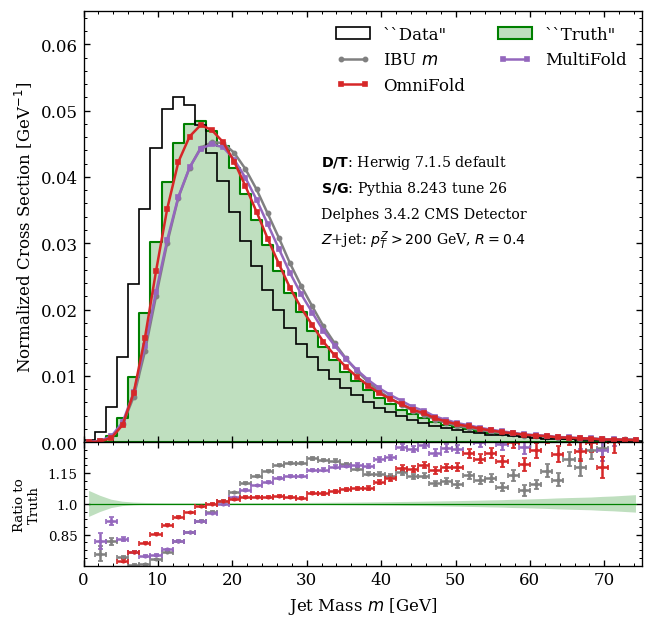

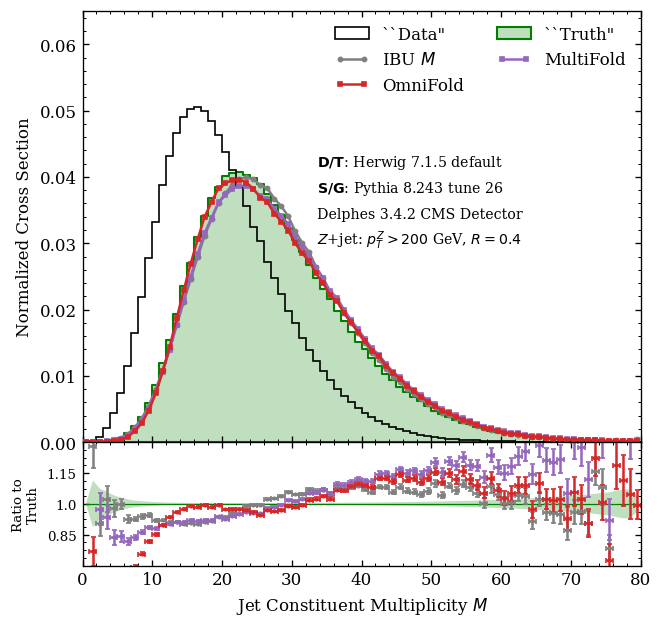

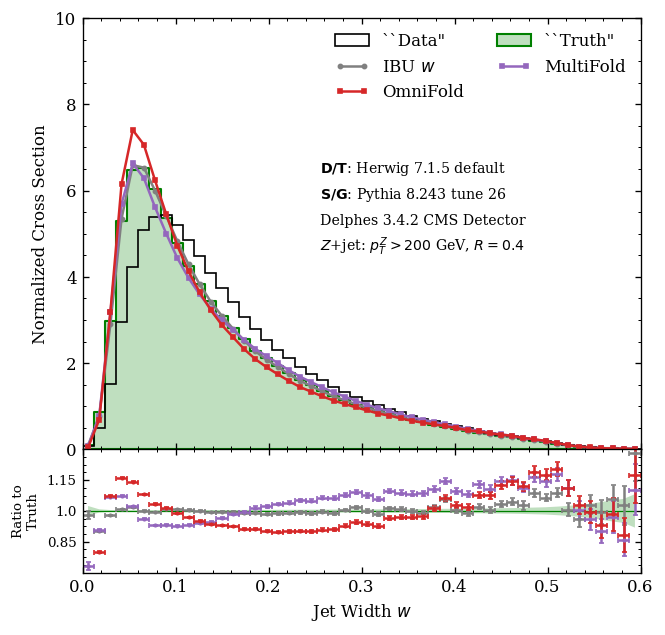

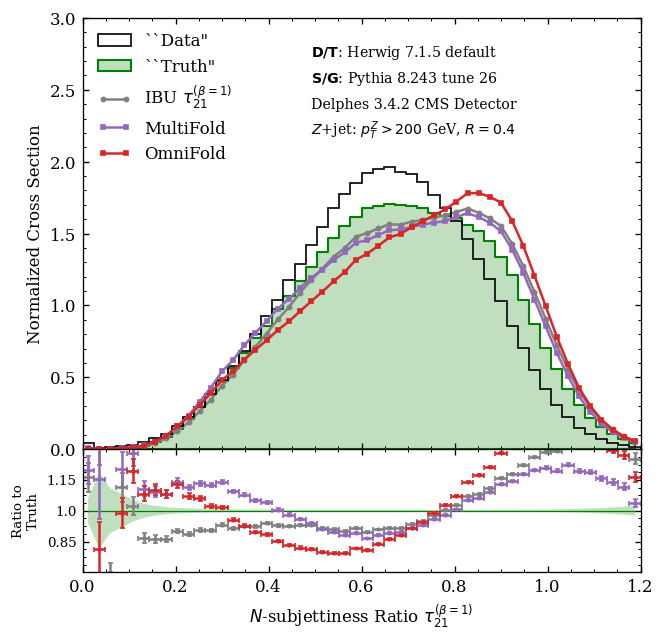

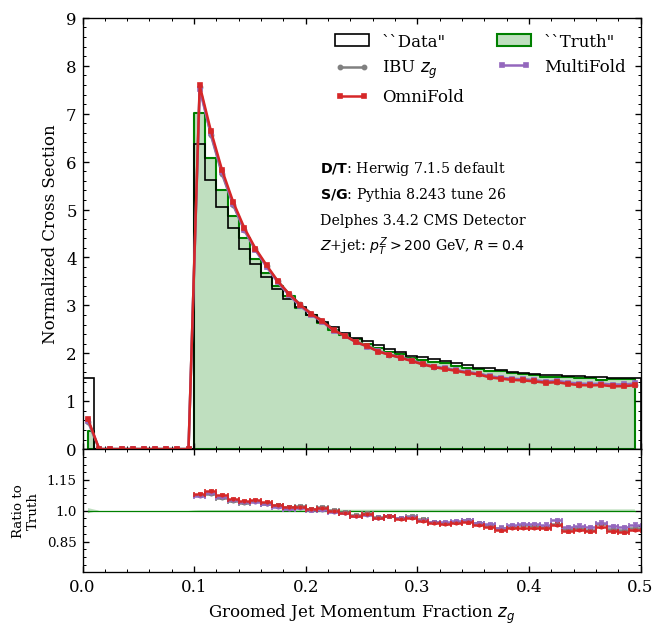

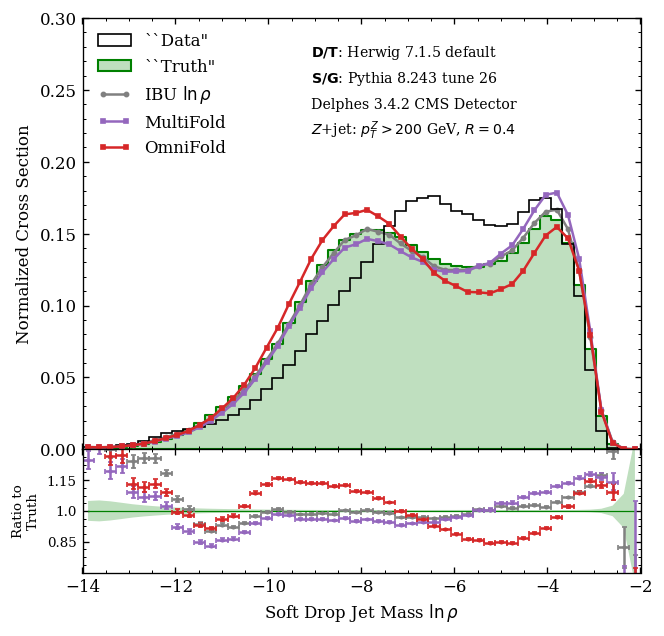

In [20]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob, figsize=(6,6))
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])
        
    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='``Data\"', **hist_style)

    # plot the "truth" histogram of the observable
    ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    # plot the IBU distribution
    ax0.plot(ob['midbins_mc'], ob['ibu_phis'][N_ITER_IBU], **ibu_style, label='IBU ' + ob['symbol'])

    # plot the MultiFold distribution
    mf_histgen, mf_histgen_unc = modplot.calc_hist(ob['genobs'], weights=model_mf.weights_pull, 
                                                   bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], mf_histgen, **multifold_style, label='MultiFold')

    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=model_of.weights_pull, 
                                                   bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='OmniFold')

    

    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    ibu_ratio = ob['ibu_phis'][N_ITER_IBU]/(ob['truth_hist'] + 10**-50)
    mf_ratio = mf_histgen/(ob['truth_hist'] + 10**-50)
    of_ratio = of_histgen/(ob['truth_hist'] + 10**-50)
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)
    ibu_unc_ratio = ob['ibu_phi_unc']/(ob['truth_hist'] + 10**-50)
    mf_unc_ratio = mf_histgen_unc/(ob['truth_hist'] + 10**-50)
    of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)
    ax1.errorbar(ob['midbins_mc'], ibu_ratio, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio, 
                                              color=ibu_style['color'], **modplot.style('errorbar'))
    ax1.errorbar(ob['midbins_mc'], mf_ratio, xerr=ob['binwidth_mc']/2, yerr=mf_unc_ratio, 
                                              color=multifold_style['color'], **modplot.style('errorbar'))
    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [0, 2, 4, 1, 3] if ncol==2 else [0, 1, 2, 3, 4]
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'$\mathbf{D/T}$: Herwig 7.1.5 default',
                  line_1=r'$\mathbf{S/G}$: Pythia 8.243 tune 26',
                  line_2=r'Delphes 3.4.2 CMS Detector',
                  line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')
    
    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    plt.show()

AttributeError: 'MultiFold' object has no attribute 'weights_push'

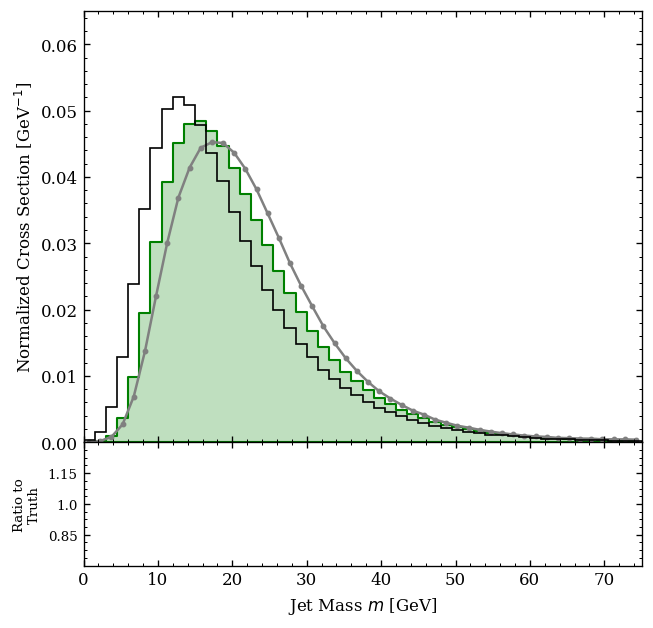

In [13]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob, figsize=(6,6))
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])
        
    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='``Data\"', **hist_style)

    # plot the "truth" histogram of the observable
    ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    # plot the IBU distribution
    ax0.plot(ob['midbins_mc'], ob['ibu_phis'][N_ITER_IBU], **ibu_style, label='IBU ' + ob['symbol'])

    # plot the MultiFold distribution
    mf_histgen, mf_histgen_unc = modplot.calc_hist(ob['genobs'], weights=model_mf.weights_pull*model_mf.weights_push, 
                                                   bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], mf_histgen, **multifold_style, label='MultiFold')

    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=model_of.weights_pull*model_of.weights_push, 
                                                   bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='OmniFold')

    

    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    ibu_ratio = ob['ibu_phis'][N_ITER_IBU]/(ob['truth_hist'] + 10**-50)
    mf_ratio = mf_histgen/(ob['truth_hist'] + 10**-50)
    of_ratio = of_histgen/(ob['truth_hist'] + 10**-50)
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)
    ibu_unc_ratio = ob['ibu_phi_unc']/(ob['truth_hist'] + 10**-50)
    mf_unc_ratio = mf_histgen_unc/(ob['truth_hist'] + 10**-50)
    of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)
    ax1.errorbar(ob['midbins_mc'], ibu_ratio, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio, 
                                              color=ibu_style['color'], **modplot.style('errorbar'))
    ax1.errorbar(ob['midbins_mc'], mf_ratio, xerr=ob['binwidth_mc']/2, yerr=mf_unc_ratio, 
                                              color=multifold_style['color'], **modplot.style('errorbar'))
    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [0, 2, 4, 1, 3] if ncol==2 else [0, 1, 2, 3, 4]
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'$\mathbf{D/T}$: Herwig 7.1.5 default',
                  line_1=r'$\mathbf{S/G}$: Pythia 8.243 tune 26',
                  line_2=r'Delphes 3.4.2 CMS Detector',
                  line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')
    
    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    plt.show()

In [ ]:
for i,(obkey,ob) in enumerate(obs.items()):
    
#     # get the styled axes on which to plot
#     fig, [ax0, ax1] = modplot.axes(**ob)
#     if ob.get('yscale') is not None:
#         ax0.set_yscale(ob['yscale'])
        
#     # Plot the Different Distributions of the Observable
#     # plot the "data" histogram of the observable
#     ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='``Data\"', **hist_style)

#     # plot the "sim" histogram of the observable
#     ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style)

#     # plot the "gen" histogram of the observable
#     ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

#     # plot the "truth" histogram of the observable
#     ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)
    
#     # Plot the Unfolded Distributions of the Observable

#     # plot the MultiFold distribution
#     mf_histgen, mf_histgen_unc = modplot.calc_hist(ob['genobs'], weights=model_mf.weights_pull, 
#                                                    bins=ob['bins_mc'], density=True)[:2]
#     ax0.plot(ob['midbins_mc'], mf_histgen, **multifold_style, label='MultiFold')

#     # plot the OmniFold distribution
#     of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=model_of.weights_pull, 
#                                                    bins=ob['bins_mc'], density=True)[:2]
#     ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='OmniFold')

#     # plot the IBU distribution
#     ax0.plot(ob['midbins_mc'], ob['ibu_phis'][N_ITER_IBU], **ibu_style, label='IBU ' + ob['symbol'])

#     # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
#     ibu_ratio = ob['ibu_phis'][N_ITER_IBU]/(ob['truth_hist'] + 10**-50)
#     mf_ratio = mf_histgen/(ob['truth_hist'] + 10**-50)
#     of_ratio = of_histgen/(ob['truth_hist'] + 10**-50)
#     ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
#     # ratio uncertainties
#     truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)
#     ibu_unc_ratio = ob['ibu_phi_unc']/(ob['truth_hist'] + 10**-50)
#     mf_unc_ratio = mf_histgen_unc/(ob['truth_hist'] + 10**-50)
#     of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
#     ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
#                      facecolor=truth_style['facecolor'], zorder=-2)
#     ax1.errorbar(ob['midbins_mc'], ibu_ratio, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio, 
#                                               color=ibu_style['color'], **modplot.style('errorbar'))
#     ax1.errorbar(ob['midbins_mc'], mf_ratio, xerr=ob['binwidth_mc']/2, yerr=mf_unc_ratio, 
#                                               color=multifold_style['color'], **modplot.style('errorbar'))
#     ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
#                                               color=omnifold_style['color'], **modplot.style('errorbar'))

#     # legend style and ordering
#     loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
#     order = [3, 4, 2, 5, 0, 1, 6] if ncol==2 else [3, 5, 4, 0, 2, 1, 6]
#     modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

#     # stamp to put on the plots
#     modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
#                   line_0=r'$\mathbf{D/T}$: Herwig 7.1.5 default',
#                   line_1=r'$\mathbf{S/G}$: Pythia 8.243 tune 26',
#                   line_2=r'Delphes 3.4.2 CMS Detector',
#                   line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')
    
#     # save plot (by default in the same directory as this notebook).
#     # If running on binder, the plot can be accessed by first going to the jupyter file browser
#     # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
#     # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
#     plt.show()